# 電波ポインティング解析

## 初期処理
- 以下の定数 (大文字の変数名のもの) を各自で設定すること
  - `sys.path` の操作については PyPl ではなくローカルのパッケージを使いたい時に使用すること

In [1]:
# ======================================================================
DATETIME = "20241216_235202"  # データファイル名の日時部分 "YYYYMMDD_HHMMSS"
# ======================================================================
PLANET = "sun"  # 観測対象  e.g. "sun", "moon"
RAWDATA_PATH = f"/1p85m/ex_hdd01/v4/RawData/necst_radiopointing_{DATETIME}_{PLANET}"  # 観測データのパス
SPECTRAL_NAME = "xffts-board1"  # 解析に使用する分光データ
SAVE_PATH = f"./{DATETIME}_{PLANET}"# 解析結果の保存先

# RAWDATA_PATH = "/1p85m/ex_hdd01/v4/RawData/test_20241118_saturn"  # temp

BAD_CH = [  # スプリアスとして除外するチャンネル範囲
    (9000,9100), (10000, 13000), (15000, 16000),  # sprious
    (16000, 17000),  # center of ch
    (26000, 32767),  # approx. 2000-2500 MHz
]

PATH_NERCST = "/1p85m/nercst"
PATH_NECLIB = "/1p85m/neclib"
# ======================================================================
import pprint
import sys

if PATH_NERCST not in sys.path:
    sys.path.insert(0, PATH_NERCST)
if PATH_NECLIB not in sys.path:
    sys.path.insert(0, PATH_NECLIB)
pprint.pprint(sys.path)
# ======================================================================

['/1p85m/neclib',
 '/1p85m/nercst',
 '/usr/local/lib/python39.zip',
 '/usr/local/lib/python3.9',
 '/usr/local/lib/python3.9/lib-dynload',
 '',
 '/1p85m/ex_hdd01/v4/nakagawa/.venv/lib/python3.9/site-packages']


- 以降は設定不要

In [2]:
%matplotlib inline
import bisect
from glob import glob
import math
from typing import List, Literal, Tuple

import necstdb
import nercst
import os
from pathlib import Path
import shutil
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import pandas as pd
import numpy as np
from astropy import constants as const
from astropy.convolution import Box1DKernel, convolve
from scipy import optimize
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit

from astropy.time import Time
from astropy.coordinates import get_body, AltAz
from astropy import units as u
from neclib.coordinates import PointingError

from neclib import config
from neclib.core import Parameters

2024-12-17 10:36:32,246: [ERROR: configuration.py#L228] No telescope specified, using default config....
2024-12-17 10:36:32,247: [ERROR: configuration.py#L241] Config file not found, using the default parameters. To create the file with default parameters, run `neclib.configure()`.


In [3]:
print(nercst.__path__)
import neclib
print(neclib.__path__)

['/1p85m/nercst/nercst']
['/1p85m/neclib/neclib']


In [4]:
def integ_exclude_sprious(db, exclude: List[Tuple[int, int]]) -> np.ndarray:
    """指定したスプリアス範囲を除いて total power を算出する"""
    # 軸の範囲を作成
    all_indices = np.arange(db.data.shape[1])  # shape[1] は ch の次元
    # 除外する範囲のマスクを作成
    mask = np.ones_like(all_indices, dtype=bool)  # すべて True に初期化
    for start, end in exclude:
        mask[start:end+1] = False  # 除外範囲を False に設定
    
    # マスクを適用して除外した範囲以外の和を計算
    integrated = np.sum(db.data[:, mask], axis=1)
    # 比較用
    integrated_full = np.sum(db.data, axis=1)
    
    fig = plt.figure(figsize=(12, 5))
    ax = fig.add_subplot(1, 1, 1)
    ax.plot(integrated_full)
    ax.plot(integrated)
    ax.title.set_text(str(rawdata_path / spectral_name))
    ax.set_yscale("log")
    ax.set_xlabel("time index")
    ax.set_ylabel("total power")
    ax.legend(["full ch integrated", "excluded sprious ch"])

    return integrated

def gaussian_func(x, a, mu, sigma):
    """ガウス関数

    Parameters
    ----------
    x
        x座標。
    a
        振幅。
    mu
        中心位置を示す値。
    sigma
        標準偏差。
    """
    return a * np.exp(- (x - mu) ** 2 / (2 * sigma ** 2))

def find_nearest_index(lst: List[float], target: float) -> int:
    """
    昇順に並んだ数値のリストの中で指定された数値に最も近い要素のインデックスを返す。
    
    Parameters
    ----------
    lst
        昇順に並んだ数値のリスト。
    target
        対象となる数値。この数値に最も近いリスト内の要素のインデックスを探す。
        
    Returns
    -------
    int
        `target`に最も近い要素のインデックス。
    
    Example
    -------
    >>> l = [0.5, 1.2, 3.4, 7.6, 8.9]
    >>> find_nearest_index(l, 3.1)
    2
    """
    pos = bisect.bisect_left(lst, target)
    
    if pos == 0:
        return 0
    if pos == len(lst):
        return len(lst) - 1
    
    before = pos - 1
    after = pos
    if abs(lst[after] - target) < abs(lst[before] - target):
        return after
    else:
        return before

def make_id_index(data) -> List[List[List[int]]]:
    id_index = []
    _id_index = []
    __id_index = []
    prev_cross = 0
    prev_axis = 0
    id_values = data.id.values
    # id_values = np.append(id.values, b"9999")  # 末尾のスキャンを処理するためのダミーが必要だが、既にIDデータ配列の末尾に9999が含まれているため不要

    for i, _x in enumerate(id_values):
        x = _x.decode().strip()
        if x == "":
            continue

        if "-" not in x:  # x: 9999 (final hot and off)
            _id_index.append(__id_index)
            id_index.append(_id_index)
            break

        if int(x[-1]) != prev_axis:  # axis: 0 (Az) or 1 (El)
            _id_index.append(__id_index)
            __id_index = []

        if int(x[:-2]) != prev_cross:  # cross_id: 0, 1, 2, ..., n-1
            id_index.append(_id_index)
            _id_index = []

        __id_index.append(i)
        prev_cross = int(x[:-2])
        prev_axis = int(x[-1])
    
    return id_index

def get_scan_time(cross_id: int, axis: int) -> Tuple[float, float]:
    """指定されたスキャンの始点、終点の時刻を順に返す。"""
    id_index = make_id_index(data)
    end_idx = id_index[cross_id][axis][-1]
    start_time = data.t.data[end_idx] - one_scan_time.to(u.s).value
    end_time = data.t.data[end_idx]
    return start_time, end_time

def get_scan_range(cross_id: int, axis: int) -> Tuple[int, int, int]:
    """指定されたスキャンの始点、中点、終点のインデックスを順に返す。"""
    id_index = make_id_index(data)
    end_idx = id_index[cross_id][axis][-1]
    start_time, end_time = get_scan_time(cross_id, axis)
    center_time = (start_time + end_time) / 2
    finded_start = find_nearest_index(data.t, start_time)
    if finded_start >= id_index[cross_id][axis][0]:
        start_idx = finded_start
        center_idx = find_nearest_index(data.t.data, center_time)
    else:
        # 推定されるスキャンの始点が見つからなかった場合、スキャンが中断された可能性がある
        start_idx = id_index[cross_id][axis][0]
        center_idx = (start_idx + end_idx) // 2
    return start_idx, center_idx, end_idx

/1p85m/ex_hdd01/v4/RawData/necst_radiopointing_20241216_235202_sun


/1p85m/ex_hdd01/v4/nakagawa/.venv/lib/python3.9/site-packages/erfa/core.py:4523: RuntimeWarning: invalid value encountered in atoiq
  ri, di = ufunc.atoiq(type, ob1, ob2, astrom)
/1p85m/ex_hdd01/v4/nakagawa/.venv/lib/python3.9/site-packages/erfa/core.py:4620: RuntimeWarning: invalid value encountered in ld
  p1 = ufunc.ld(bm, p, q, e, em, dlim)
/1p85m/ex_hdd01/v4/nakagawa/.venv/lib/python3.9/site-packages/erfa/core.py:19004: RuntimeWarning: invalid value encountered in anp
  c_retval = ufunc.anp(a)
/1p85m/ex_hdd01/v4/nakagawa/.venv/lib/python3.9/site-packages/erfa/core.py:4620: RuntimeWarning: invalid value encountered in ld
  p1 = ufunc.ld(bm, p, q, e, em, dlim)
/1p85m/ex_hdd01/v4/nakagawa/.venv/lib/python3.9/site-packages/erfa/core.py:19004: RuntimeWarning: invalid value encountered in anp
  c_retval = ufunc.anp(a)
/1p85m/ex_hdd01/v4/nakagawa/.venv/lib/python3.9/site-packages/erfa/core.py:4036: RuntimeWarning: invalid value encountered in atioq
  aob, zob, hob, dob, rob = ufunc.atioq

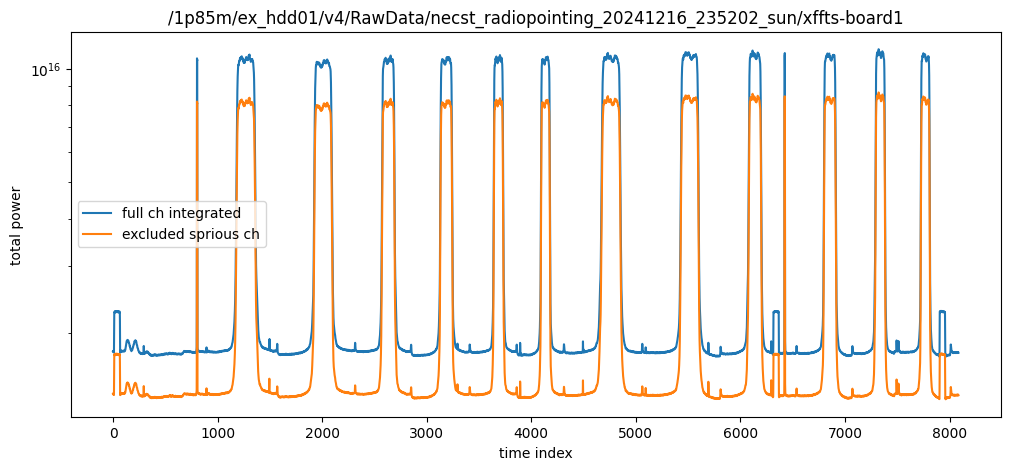

In [6]:
# パスの設定
rawdata_path = Path(RAWDATA_PATH)
spectral_name = Path(SPECTRAL_NAME)
save_path = Path(SAVE_PATH)
print(rawdata_path)

# 拡張子tomlの観測指示書の検索、読み込み、コピー
impl = rawdata_path.glob("*.toml")
for p in impl:
    if p.name.endswith("_config.toml"):
        shutil.copy(rawdata_path / p.name, rawdata_path / "config.toml")
    elif p.name not in ["config.toml", "device_setting.toml", "pointing_param.toml"]:
        shutil.copy(f"{rawdata_path / p.name}", f"{rawdata_path / p.name[:-5]}.obs")

obs_param = Parameters.from_file(glob(str(rawdata_path / "*.obs"))[0])
obs_speed = obs_param.speed
obs_radius_az = obs_param.max_separation_az
obs_radius_el = obs_param.max_separation_el
if obs_radius_az == obs_radius_el:
    one_scan_time = abs(obs_radius_az * 2 / obs_speed)
else:
    raise NotImplementedError()

# 観測データの読み込み
data = nercst.core.io.loaddb(str(rawdata_path), str(spectral_name), telescop="OMU1p85m")
data = nercst.core.multidimensional_coordinates.convert_frame(data, "altaz")

os.environ["NECST_ROOT"] = str(data.config_filepath.parent)
config.reload()

df = pd.DataFrame(columns=["time", "integrated", "lon", "lat", "lon_cor", "lat_cor"])
integrated = integ_exclude_sprious(db=data, exclude=BAD_CH)

df.integrated = integrated
df.lon = data.lon  # Az_enc
df.lat = data.lat  # El_enc
df.lon_cor = data.lon_cor  # Az_sky
df.lat_cor = data.lat_cor  # El_sky
df.time = data.t

pe = PointingError.from_file(data.config_filepath.parent / "pointing_param.toml")
t = Time(df.time, format="unix")
reference = get_body(PLANET, location=config.location, time=t)
press = data.pressure.values * u.hPa
temp = (data.temperature.values * u.K).to(u.deg_C, equivalencies=u.temperature())
humid = data.humidity.values
obswl = const.c / config.observation_frequency
altaz = AltAz(obstime=t, location=config.location, pressure=press, temperature=temp, relative_humidity=humid, obswl=obswl)
reference_altaz = reference.transform_to(altaz)
reference_enc = pe.refracted_to_apparent(reference_altaz.az, reference_altaz.alt)  # この変換いらないらしいが？やっぱりいると思う
# reference_enc = reference_altaz.az, reference_altaz.alt  # 代わりにこっち？
offset_az = df.lon.values - reference_enc[0].value
offset_el = df.lat.values - reference_enc[1].value
# offset_az = df.lon_cor - self.reference_altaz.az.value
# offset_el = df.lat_cor - self.reference_altaz.alt.value
# print(f"offset_az: {offset_az}")
# print(f"offset_el: {offset_el}")

df["offset_az"] = offset_az
df["offset_el"] = offset_el
df["position"] = data.position
df["offset_x"] = offset_az * np.cos((reference_enc[1].value * u.deg).to(u.rad)).value
df["id"] = data.id

id_index = make_id_index(data)

scans = np.unique(df["id"])
scan_num = (len(id_index) - 1) * 2 + len(id_index[-1]) if id_index != [] else 0
# self.lim_df_scan = None#self.df_scan[] # scanの端を切り取る
# self.scan_total = len(np.unique(df["id"]))

# self.d = None
# self.centre_az = None
# self.centre_el = None

# 保存ディレクトリの作成
if not os.path.exists(save_path):
    os.makedirs(save_path)

In [7]:
altaz

<AltAz Frame (obstime=[1.73439312e+09 1.73439312e+09 1.73439312e+09 ... 1.73439393e+09
 1.73439393e+09 1.73439393e+09], location=(-3871165.06944156, 3428273.15427448, 3723695.62006595) m, pressure=[863. 863. 863. ...  nan  nan  nan] hPa, temperature=[6.1 6.1 6.1 ... nan nan nan] deg_C, relative_humidity=[0.561 0.561 0.561 ...   nan   nan   nan], obswl=1300.4036557964412 micron)>

In [8]:
b1 = -0.005425000774038015
b2 = -0.035801684660305394
b3 = 2.4558633143025608
b4 = 0.005526711469759163
b5 = -0.0003764241636554557
b6 = -0.5187954880693784
b7 = -0.0011449917228347143

a1 = -0.017297889370905258
a2 = 0.019932118906155788
a3 = 2.4235584317039462
a4 = 0.007318911360098779
a5 = -0.004695853513104079
a6 = -0.6856095218516536
a7 = 0.0001613560772320849

print((a1 - b1) * 3600)
print((a2 - b2) * 3600)
print((a3 - b3) * 3600)
print((a4 - b4) * 3600)
print((a5 - b5) * 3600)
print((a6 - b6) * 3600)
print((a7 - b7) * 1)

-42.74239894872208
200.64169283926026
-116.2975773550123
6.451919605222617
-15.549945658015044
-600.5305216161908
0.0013063478000667993


In [9]:
db = necstdb.opendb(rawdata_path)
cmd = db.open_table(f"necst-OMU1P85M-ctrl-antenna-altaz").read(astype="df")
enc = db.open_table(f"necst-OMU1P85M-ctrl-antenna-encoder").read(astype="df")

In [10]:
start_time, end_time = get_scan_time(0, 0)
start_idx = find_nearest_index(enc.time.values, start_time)
end_idx = find_nearest_index(enc.time.values, end_time)
start_idx, end_idx

(1167, 1753)

In [11]:
one_scan_time.to(u.s)/ (1 + (5 % 3) / 2)

<Quantity 25. s>

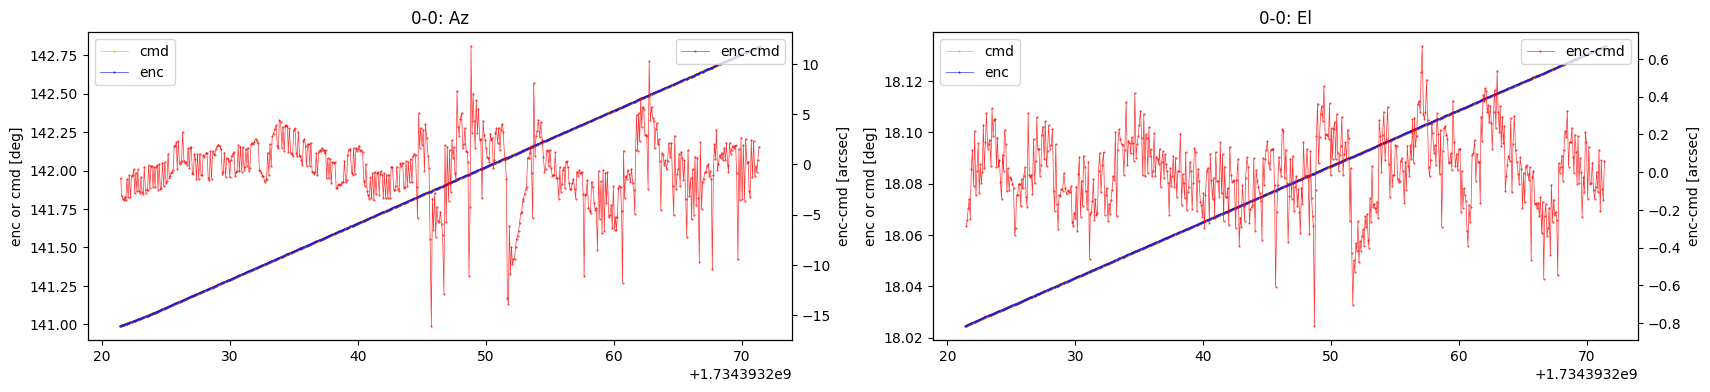

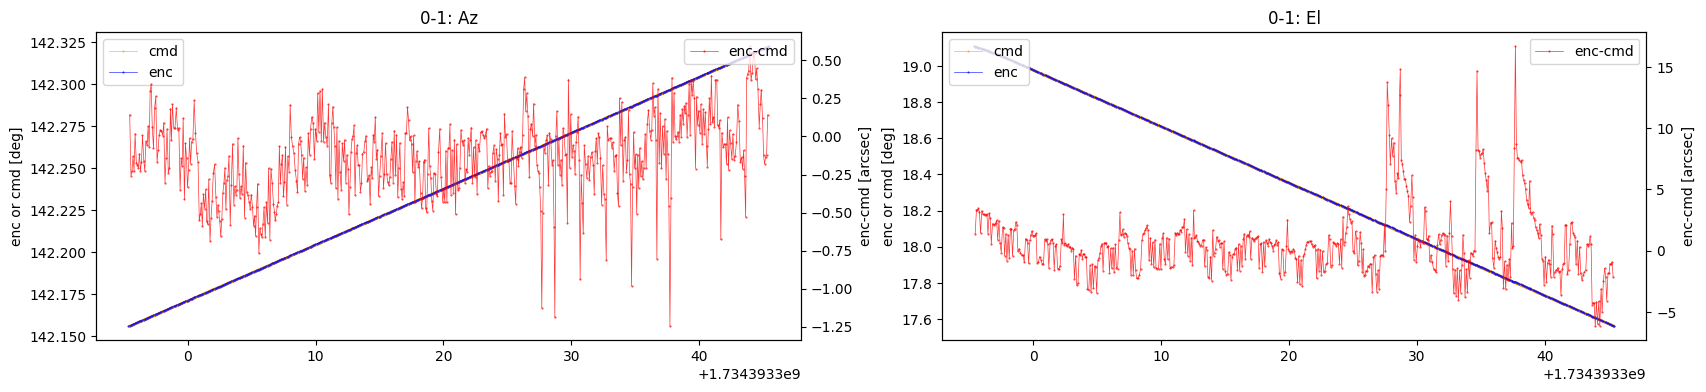

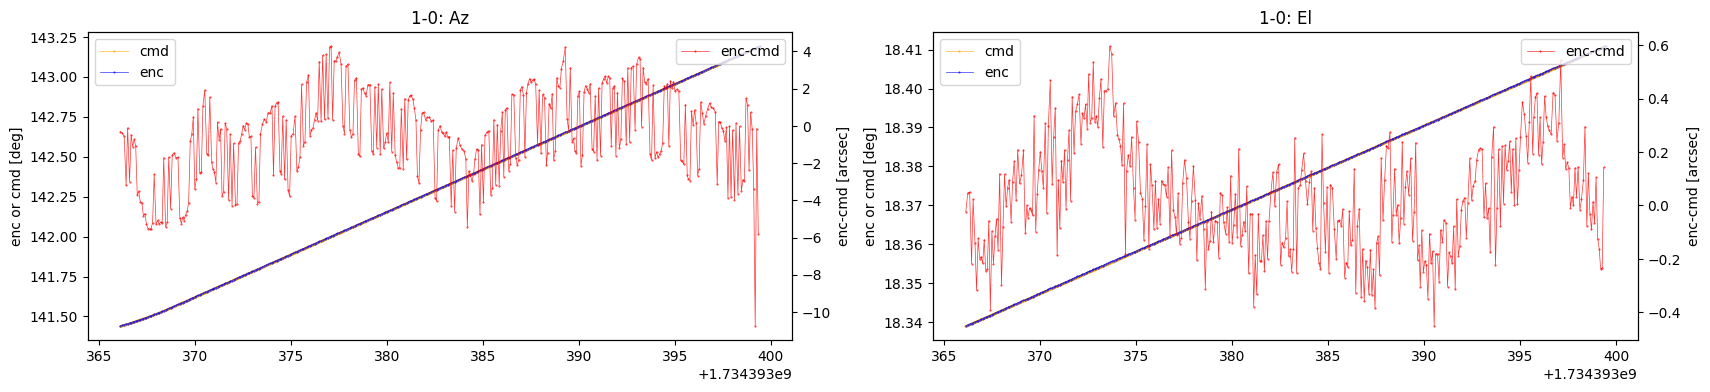

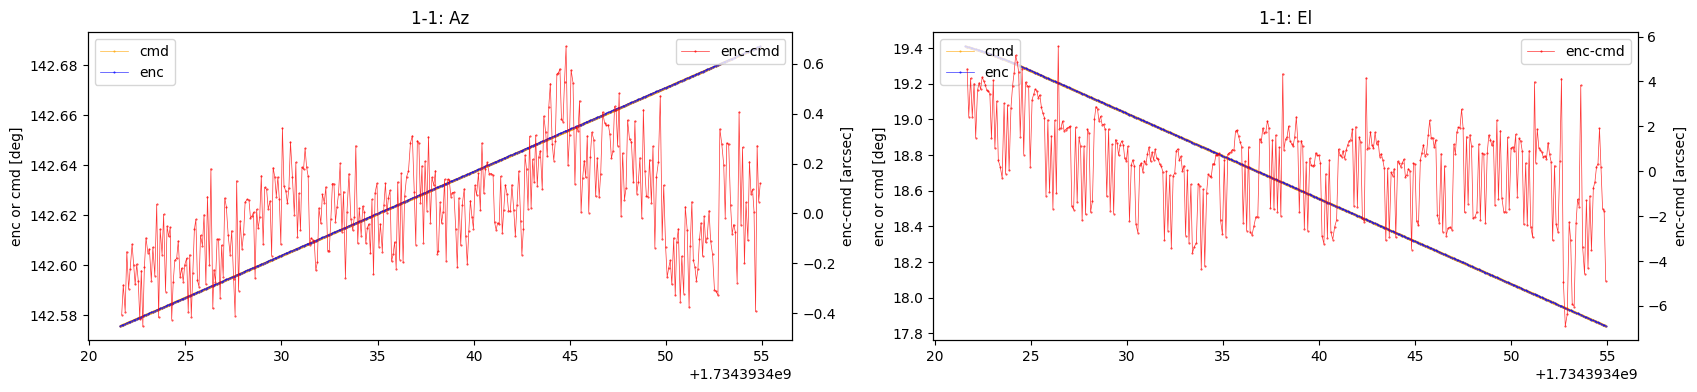

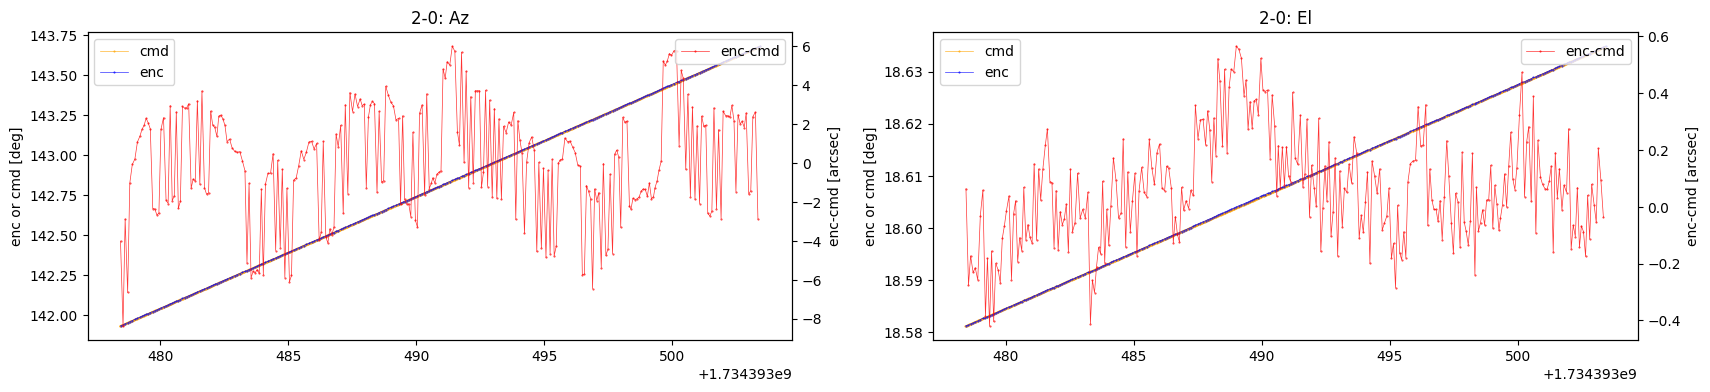

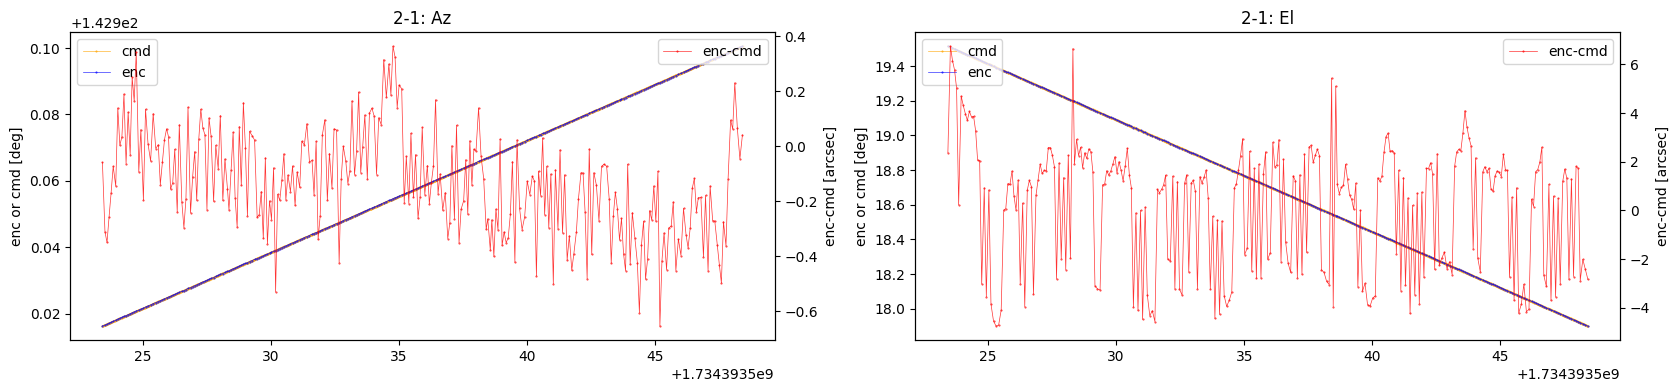

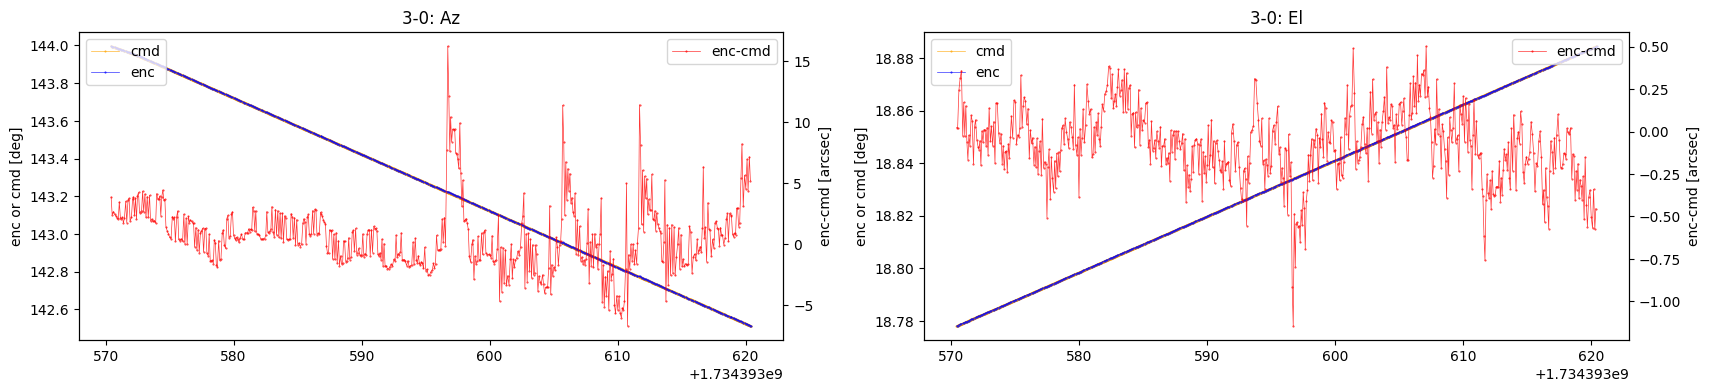

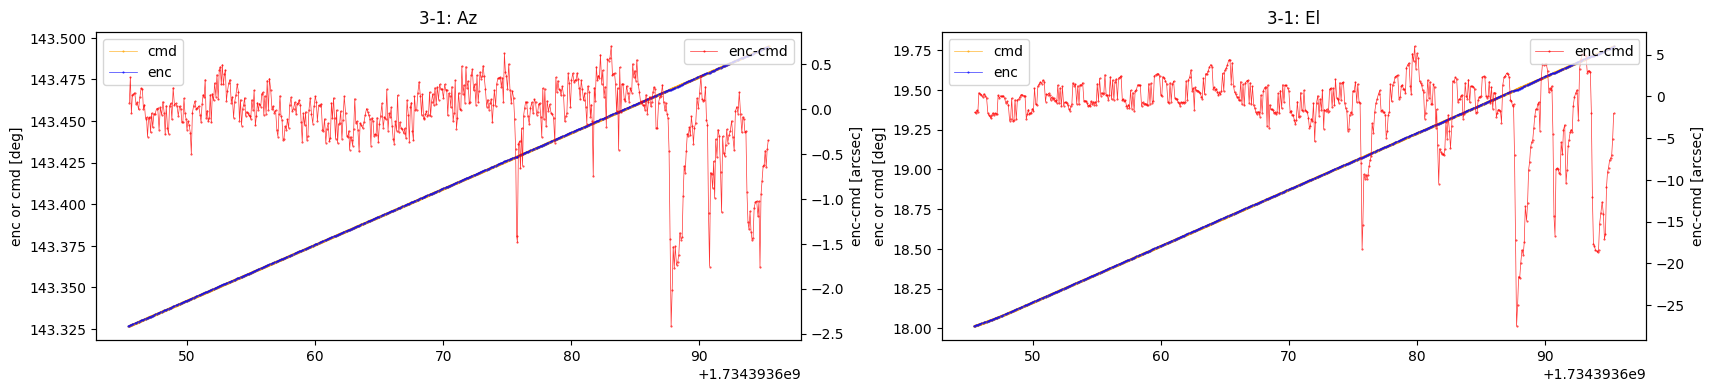

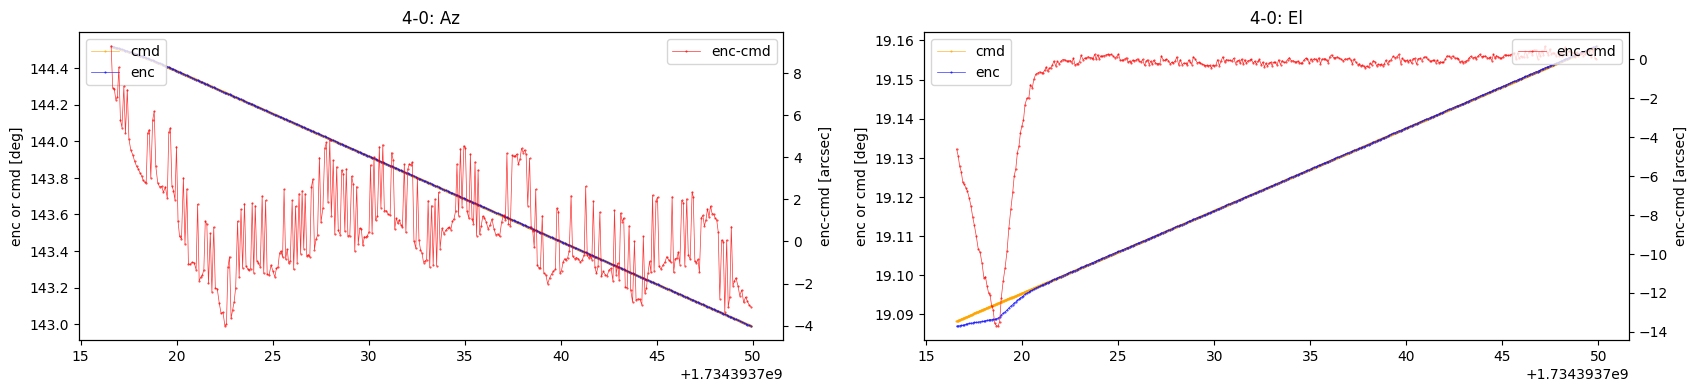

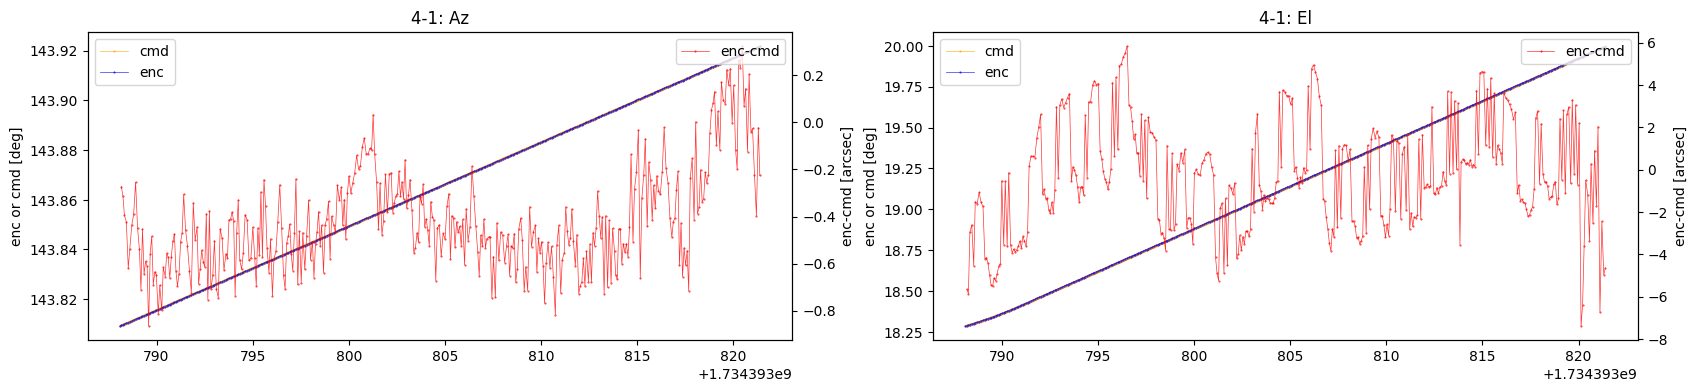

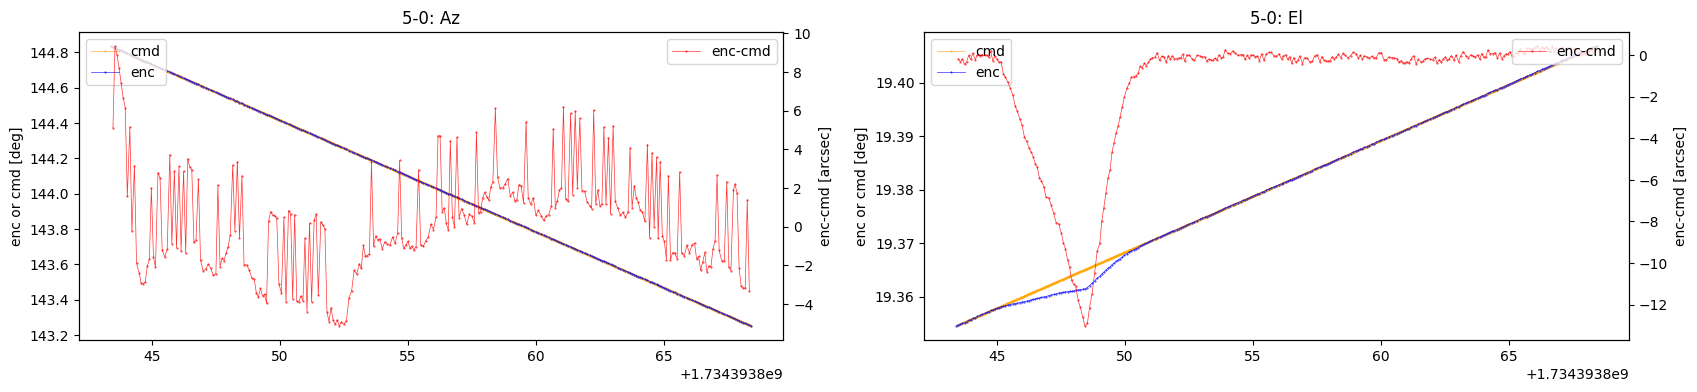

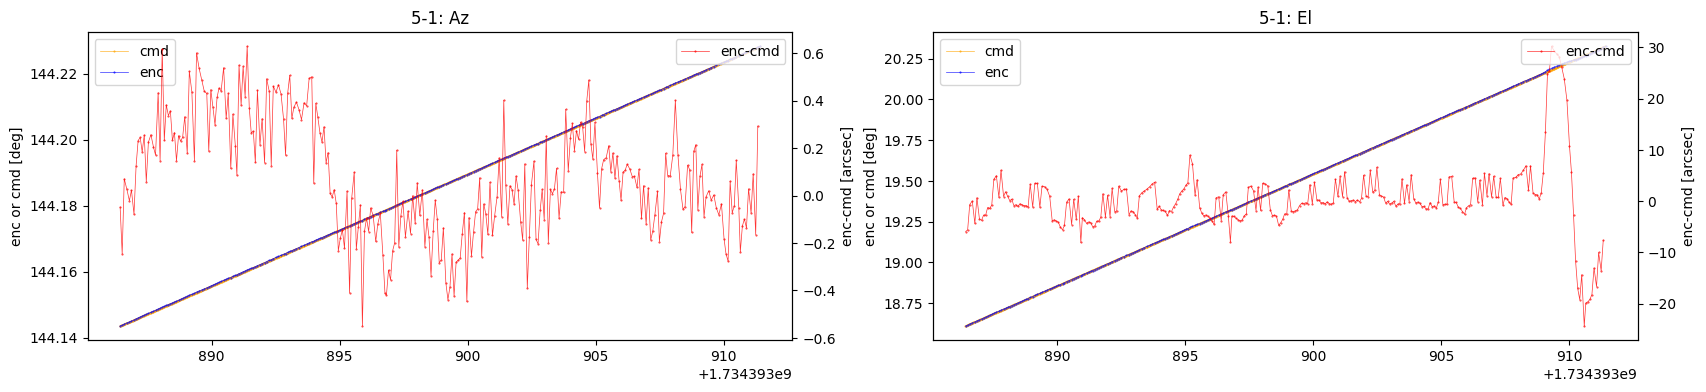

In [30]:
_one_scan_time = one_scan_time
for i in range(0, 6):
    one_scan_time = _one_scan_time / (1 + (i % 3) / 2)
    for j in range(2):
        start_time, end_time = get_scan_time(i, j)
        
        start_idx = find_nearest_index(enc.time.values, start_time)
        end_idx = find_nearest_index(enc.time.values, end_time)
        et = enc.time.values[start_idx:end_idx+1]  # np.ndarray
        eaz = enc.lon.values[start_idx:end_idx+1]
        eel = enc.lat.values[start_idx:end_idx+1]
        # eazr, eelr = apparent_to_refracted(eaz, eel)

        start_idx = find_nearest_index(cmd.time.values, start_time)
        end_idx = find_nearest_index(cmd.time.values, end_time)
        ct = cmd.time.values[start_idx:end_idx+1]
        caz = cmd.lon.values[start_idx:end_idx+1]
        cel = cmd.lat.values[start_idx:end_idx+1]
        iaz = interp1d(ct, caz, bounds_error=False) # 線形補間関数定義
        iel = interp1d(ct, cel, bounds_error=False)
        caz2 = iaz(et)
        cel2 = iel(et)
        
        fig = plt.figure(figsize=(20, 4))
        ax = [fig.add_subplot(1, 2, i+1) for i in range(2)]
        axt = [ax[i].twinx() for i in range(2)]
        style = {"alpha": 0.8, "marker": ".", "markersize": 1, "linewidth": 0.5}
        ax[0].title.set_text(f"{i}-{j}: Az")
        ax[1].title.set_text(f"{i}-{j}: El")
        ax[0].plot(ct, caz, label="cmd", color="orange", **style)
        ax[0].plot(et, eaz, label="enc", color="blue", **style)
        ax[1].plot(ct, cel, label="cmd", color="orange", **style)
        ax[1].plot(et, eel, label="enc", color="blue", **style)
        axt[0].plot(et, (eaz - caz2) * 3600, label="enc-cmd", color="red", **style)
        axt[1].plot(et, (eel - cel2) * 3600, label="enc-cmd", color="red", **style)
        [ax[i].legend(loc="upper left") for i in range(2)]
        [ax[i].set_ylabel("enc or cmd [deg]") for i in range(2)]
        [axt[i].legend(loc="upper right") for i in range(2)]
        [axt[i].set_ylabel("enc-cmd [arcsec]") for i in range(2)]
one_scan_time = _one_scan_time

In [14]:
get_scan_range(3, 0)

(4480, 4730, 4980)

In [15]:
np.arange(2, 1, 1/4)

array([], dtype=float64)

In [16]:
# fig = plt.figure(figsize=(6, 5))
# ax1 = fig.add_subplot(1, 1, 1)
# ax2 = ax1.twinx()
# start, _, end = get_scan_range(3, 1)
# speed = 120  # arcsec/s
# _daz = offset_az[start:end+1] * 3600
# _del = offset_el[start:end+1] * 3600 - np.arange(-1800, 1812, speed * 0.1)
# ax1.plot(_daz, color="blue", alpha=0.5, label="enc-ref of Az")
# ax2.plot(_del, color="orange", alpha=0.5, label="enc-ref of El")
# ax1.title.set_text(RAWDATA_PATH)
# ax1.set_xlabel("time index")
# ax1.set_ylabel("offset_az [arcsec]")
# ax2.set_ylabel("offset_el [arcsec]")
# ax1.legend(loc="upper left")
# ax2.legend(loc="upper right")

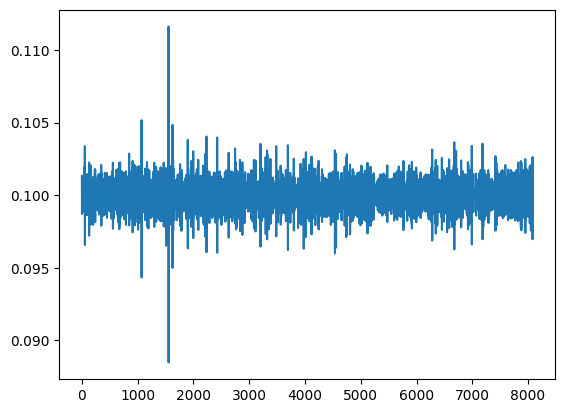

In [17]:
plt.plot(df.time.diff())

990          NaN
991     0.100110
992     0.100182
993     0.100126
994     0.099673
          ...   
1486    0.100096
1487    0.101523
1488    0.098524
1489    0.100029
1490    0.100005
Name: time, Length: 501, dtype: float64
990            NaN
991      62.283306
992      80.205789
993     168.088562
994      82.060507
           ...    
1486     95.560729
1487    211.907798
1488    119.812898
1489    123.731538
1490    112.782730
Length: 501, dtype: float64


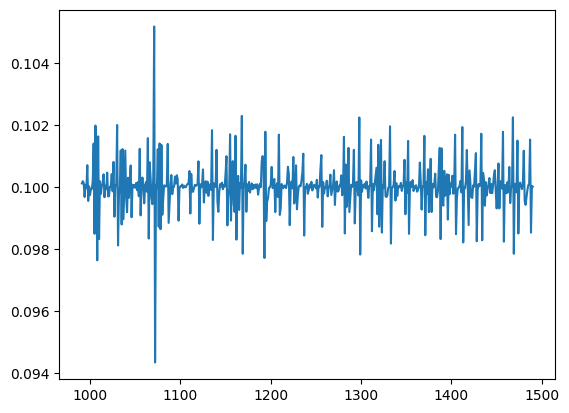

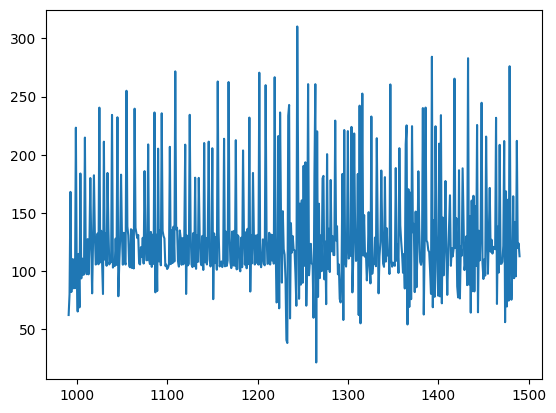

In [18]:
start, _, end = get_scan_range(0, 0)
l = df.lon[start:end+1]
t = df.time[start:end+1]
l_diff = l.diff() * 3600
t_diff = t.diff()
print(t_diff)
plt.plot(t_diff)
print(l_diff / t_diff)
plt.figure()
plt.plot(l_diff / t_diff)
# plt.ylim(0, 250)

In [19]:
# ldm = []
# for i in range(scan_num):
#     start, _, end = get_scan_range(i // 2, i % 2)
#     if i % 2 == 0:
#         l = df.lon[start:end+1]
#     else:
#         l = df.lat[start:end+1]
#     l_diff = l.diff()
#     ldm.append(abs(l_diff).max())
# plt.plot(ldm)

In [20]:
start, _, end = get_scan_range(0, 0)

# 解析に必要な関数の定義

In [21]:
class planetAnalysis():
    def __init__(self, cross_id: int, axis: Literal[0, 1]) -> None:
        # self.data_num = data_num
        self.scan_id = cross_id * 2 + axis
        self.cross_id = cross_id
        self.axis = axis
        self.idx_scan_start, self.idx_scan_center, self.idx_scan_end = get_scan_range(cross_id, axis)
        self.df_scan = df[self.idx_scan_start:self.idx_scan_end + 1]
        # if self.axis == 0:
        #     self.fig, self = plt.subplots(1, 2)
        #     self.fig.suptitle(str(rawdata_path))

    # def plot(self):
    #     plt.title(f"{RAWDATA_PATH}\ncross_id: {self.cross_id} - {self.axis} (scan_id: {self.scan_id})")
    #     plt.plot(self.df_scan.integrated)

    def gauss(self, start, end):
        # print(f"tp: {self.df_scan.integrated}")
        # plt.plot(self.df_scan.integrated)
        scan_data = self.df_scan.integrated.loc[start:end].values
        # print(self.df_scan.keys())
        self.scan_offset_x = self.df_scan.offset_x.loc[start:end].values[5:-5]
        self.scan_offset_el = self.df_scan.offset_el.loc[start:end].values[5:-5]
        self.scan_offset_x_interp = (self.scan_offset_x[1:] + self.scan_offset_x[:-1]) / 2
        self.scan_offset_el_interp = (self.scan_offset_el[1:] + self.scan_offset_el[:-1]) / 2

        kernel = Box1DKernel(10)
        self.scan_data_convolve = convolve(scan_data, kernel)[5:-5]  # 畳み込み結果、データの左右端が低い値になっているためそこを切る
        self.scan_data_convolve_diff = np.diff(self.scan_data_convolve)

        # f = plt.figure()
        # ax = f.add_subplot(111)
        # ax2 = ax.twinx()

        # if self.axis == "az":
        #     ax.plot(self.scan_offset_x, self.scan_data_convolve, c="red", label="frequency-integrated scan")
        #     ax.set_ylim(2.5e15,4.0e15)

        #     ax2.plot(self.scan_offset_x[1:], np.diff(self.scan_data_convolve), c="blue", label="differential")
        #     ax2.set_ylim(-3e13,5e13)
            
        # else:
        #     ax.plot(self.scan_offset_el, self.scan_data_convolve, c="red", label="frequency-integrated scan")
        #     ax.set_ylim(2.5e15,4.0e15)

        #     ax2.plot(self.scan_offset_el[1:], np.diff(self.scan_data_convolve), c="blue", label="differential")
        #     ax2.set_ylim(-3e13,5e13)

    def last(self, fig, left_param, right_param, left_range, right_range):
        last_axis = self.axis
        l_a = left_param[0]
        l_mu = left_param[1]
        l_sigma = left_param[2]
        r_a = right_param[0]
        r_mu = right_param[1]
        r_sigma = right_param[2]
        l_start = left_range[0]
        l_end = left_range[1]
        r_start = right_range[0]
        r_end = right_range[1]

        ax = fig.add_subplot((scan_num + 1) // 2, 2, self.scan_id + 1)
        ax2 = ax.twinx()

        if last_axis == 0:
            ax.plot(self.scan_offset_x, self.scan_data_convolve, c="red", label="frequency-integrated scan")

            #initial guess of the fit
            p0_left = [l_a, l_mu, l_sigma]
            p0_right = [r_a, r_mu, r_sigma]
            
            popt_left, _ = curve_fit(
                gaussian_func, 
                xdata=self.scan_offset_x_interp[l_start:l_end],
                ydata=self.scan_data_convolve_diff[l_start:l_end],
                p0=p0_left,
                maxfev=20000
            )
            popt_right, _ = curve_fit(
                gaussian_func, 
                xdata=self.scan_offset_x_interp[r_start:r_end],
                ydata=self.scan_data_convolve_diff[r_start:r_end],
                p0=p0_right,
                maxfev=20000
            )

            ax2.plot(self.scan_offset_x_interp, self.scan_data_convolve_diff, c="orange", label="differential")
            ax2.plot(self.scan_offset_x_interp[l_start:l_end], 
                     gaussian_func(
                         self.scan_offset_x_interp[l_start:l_end], 
                         popt_left[0], 
                         popt_left[1], 
                         popt_left[2]),
                    c="blue")
            ax2.plot(
                self.scan_offset_x_interp[r_start:r_end], 
                gaussian_func(self.scan_offset_x_interp[r_start:r_end], 
                              popt_right[0], 
                              popt_right[1], 
                              popt_right[2]),c="blue")
            ax.set_xlabel("offset x")
            max_range = abs(obs_radius_az.to("deg").value * 1.2)
            
        elif last_axis == 1:
            ax.plot(self.scan_offset_el, self.scan_data_convolve, c="red", label="frequency-integrated scan")

            #initial guess of the fit
            p0_left = [l_a, l_mu, l_sigma]
            p0_right = [r_a, r_mu, r_sigma]
            
            popt_left, _ = curve_fit(
                f=gaussian_func, 
                xdata=self.scan_offset_el_interp[l_start:l_end], 
                ydata=self.scan_data_convolve_diff[l_start:l_end],
                p0=p0_left,
                maxfev=20000
            )
            popt_right, _ = curve_fit(
                f=gaussian_func, 
                xdata=self.scan_offset_el_interp[r_start:r_end], 
                ydata=self.scan_data_convolve_diff[r_start:r_end],
                p0=p0_right,
                maxfev=20000
            )

            ax2.plot(self.scan_offset_el_interp, self.scan_data_convolve_diff, c="orange", label="differential")
            ax2.plot(self.scan_offset_el_interp[l_start:l_end],
                     gaussian_func(
                         self.scan_offset_el_interp[l_start:l_end], 
                         popt_left[0], 
                         popt_left[1], 
                         popt_left[2]),
                    c="blue")
            ax2.plot(
                self.scan_offset_el_interp[r_start:r_end], 
                gaussian_func(self.scan_offset_el_interp[r_start:r_end], 
                              popt_right[0], 
                              popt_right[1], 
                              popt_right[2]),c="blue")
            ax.set_xlabel("offset y")
            max_range = abs(obs_radius_el.to("deg").value * 1.2)
        
        ax.grid(which='major', linewidth=1)
        #ax.set_xlim(-0.60, 0.4)
        #ax.set_ylim(4.2e15,4.6e15)
        # ax2.set_ylim(-8e13,8e13)
        # max_range = max(abs(ax.get_xlim()[0]), abs(ax.get_xlim()[1]))
        ax.set_xlim(-max_range, max_range)
        ax.set_ylabel("total power")
        ax.set_title(f"{DATETIME}_{PLANET}\ncross_id: {self.cross_id} - {self.axis} (scan_id: {self.scan_id})")

        # print(self.scan_data_convolve)
        print(f"fitted_upper = {popt_left}")
        print(f"fitted_lower = {popt_right}")
        self.d = (popt_left[1] + popt_right[1]) / 2 * u.deg
        self.d = self.d.to(u.arcsec)
        # print(f"d = {self.d}")
        self.center_az = reference_enc[0][self.idx_scan_center]
        self.center_el = reference_enc[1][self.idx_scan_center]
        # self.centre_az = np.mean(reference_altaz.az[r_start:r_end])
        # self.centre_el = np.mean(reference_altaz.alt[r_start:r_end])
        # print(f"az = {self.center_az}")
        # print(f"el = {self.center_el}")
        ax.text(0.05, 0.05, f"d: {self.d:.2f}\nAz: {self.center_az:.2f}\nEl: {self.center_el:.2f}", transform=ax.transAxes, fontsize=10, verticalalignment="bottom")

In [22]:
class CalcD():
    def fit(fig, cross_id: int, axis: Literal[0, 1], data_range: float = 3.6e15, gauss_sigma: float = 20.0) -> None:
        print(f"==================== cross {cross_id} - {axis} (scan {cross_id * 2 + axis}) ====================")
        planet = planetAnalysis(cross_id=cross_id, axis=axis)
        # planet.plot()
        df_scan_copy = planet.df_scan.copy()
        # if df_scan_copy['integrated'].iloc[:400].max() > 0:
        #     df_scan_copy.iloc[:400, df_scan_copy.columns.get_loc('integrated')] = 0
        # elif df_scan_copy['integrated'].iloc[-300:].max() > 0:
        #     df_scan_copy.iloc[-300:, df_scan_copy.columns.get_loc('integrated')] = 0
        # else:
        #     pass
        # print(f"max_tp_idx: {((df_scan_copy.integrated) > max(df_scan_copy.integrated) - 1e4)}")
        # print(max(df_scan_copy.integrated) - 1e13)
        # plot_left = np.array(planet.df_scan.integrated[(df_scan_copy.integrated) > max(df_scan_copy.integrated) - 1e14].index).min() - 400
        # plot_right = np.array(planet.df_scan.integrated[(df_scan_copy.integrated) > max(df_scan_copy.integrated) - 1e14].index).max() + 300
        plot_left = planet.df_scan.integrated[((df_scan_copy.integrated) > max(df_scan_copy.integrated) - 1e14)].index[0] - 400/1
        plot_right = planet.df_scan.integrated[((df_scan_copy.integrated) > max(df_scan_copy.integrated) - 1e14)].index[-1] + 300/1
        planet.gauss(plot_left, plot_right)
        diff = np.diff(planet.scan_data_convolve)[10:-10]
        # print(planet.scan_data_convolve)
        left_min = np.array(np.where(diff > max(diff) - 1.0e12)).min() - 10
        left_min = max(left_min, 0)
        left_max = np.array(np.where(diff > max(diff) - 1.0e12)).max() + 30
        right_min = np.array(np.where(diff < min(diff) + 1.0e12)).min() - 10
        right_min = max(right_min, 0)
        right_max = np.array(np.where(diff < min(diff) + 1.0e12)).max() + 30
        # print(f"planet.scan_data_convolve: {planet.scan_data_convolve}")  ##########
        # print(f"plot_left: {plot_left}")  ##########
        # print(f"plot_right: {plot_right}")  ##########
        # print(f"left_min: {left_min}")  ##########
        # print(f"left_max: {left_max}")  ##########
        # print(f"right_min: {right_min}")  ##########
        # print(f"right_max: {right_max}")  ##########
        plot_blue=np.diff(planet.scan_data_convolve)[left_min:left_max]
        plot_orange=np.diff(planet.scan_data_convolve)[right_min:right_max]
        # print(f"diff_left: {plot_blue}")
        # direction: 増加方向なら1、減少方向なら-1
        if axis == 0:
            direction = 1 if np.median(planet.scan_offset_x[1:] - planet.scan_offset_x[:-1]) > 0 else -1
        elif axis == 1:
            direction = 1 if np.median(planet.scan_offset_el[1:] - planet.scan_offset_el[:-1]) > 0 else -1
        # left_param = [max(plot_blue), np.argmax(plot_blue), 20]  # initial a, mu=視直径/2, sigma=0.025deg(90arcsec)
        # right_param = [min(plot_orange), np.argmin(plot_orange), 20]
        left_param = [max(plot_blue), -0.25 * direction, 0.025]
        right_param = [min(plot_orange), 0.25 * direction, 0.025]
        print(f"init_upper: {left_param}")
        print(f"init_lower: {right_param}")
        left_range = [left_min, left_max]  # fitting target range
        right_range = [right_min, right_max]

        planet.last(fig, left_param, right_param, left_range, right_range)
    
        # plt.savefig(save_path / f"tp/cross{cross_id}-{axis}.png")

        df_before = pd.read_csv(save_path / "d_param_before_reduce.csv")
        df_before.at[planet.scan_id, "dt_cross_id"] = f"{DATETIME}_{planet.cross_id}"
        df_before.at[planet.scan_id, "scan_id"] = planet.scan_id
        df_before.at[planet.scan_id, "cross_id"] = planet.cross_id
        df_before.at[planet.scan_id, "axis"] = planet.axis
        df_before.at[planet.scan_id, "Az"] = planet.center_az.value  # deg
        df_before.at[planet.scan_id, "El"] = planet.center_el.value  # deg
        df_before.at[planet.scan_id, "dx"] = planet.d.value if axis == 0 else np.nan  # arcsec
        df_before.at[planet.scan_id, "dEl"] = planet.d.value if axis == 1 else np.nan  # arcsec
        # 変更をCSVファイルに書き込む
        df_before.to_csv(save_path / "d_param_before_reduce.csv", index=False)

    def reduce(good_scan_id: List[int]):
        df_before = pd.read_csv(save_path / "d_param_before_reduce.csv")
        df_after = df_before.iloc[good_scan_id]
        # 変更をCSVファイルに書き込む
        df_after.to_csv(save_path / "d_param.csv", index=False)

In [23]:
# !pip install joblib
# from joblib import Parallel, delayed
# from IPython.display import display

# def process_planet(i):
#     plt.figure()
#     planet = planetAnalysis(cross_id=i // 2, axis=i % 2)
#     planet.plot()
#     return plt.gcf()


# figures = Parallel(n_jobs=-1)(delayed(process_planet)(i) for i in range(scan_num))


# for fig in figures:
#     display(fig)
#     plt.close(fig)

# スキャン解析実行 (TP・fitting 確認)【重要：要目視判断】
事前に各 `scan_id` の TP や fitting 結果を確認し、<br>
天体が受かっていないものや正常に fitting できていないものは `BAD_SCAN_ID` として以下の「データ抽出・保存」で除外すること<br>
- `cross_id`：何回目のクロススキャンか
- `scan_id`：何回目のスキャンか

|cross_id|scan_id (Az 方向)|scan_id (El 方向)|
|:-:|:-:|:-:|
|0|0|1|
|1|2|3|
|2|4|5|
|...|...|...|
|n|2n|2n+1|

Fitting 12 scan(s)...
==================== cross 0 - 0 (scan 0) ====================
init_upper: [316422600000000.0, -0.25, 0.025]
init_lower: [-310519160000000.0, 0.25, 0.025]
fitted_upper = [ 3.10091432e+14 -2.74594982e-01  2.50289352e-02]
fitted_lower = [-3.04729355e+14  2.74771281e-01  2.50256555e-02]
==================== cross 0 - 1 (scan 1) ====================
init_upper: [353903700000000.0, 0.25, 0.025]
init_lower: [-330798920000000.0, -0.25, 0.025]
fitted_upper = [3.46630605e+14 2.76841791e-01 2.39273005e-02]
fitted_lower = [-3.31612679e+14 -2.70732157e-01  2.46868625e-02]
==================== cross 1 - 0 (scan 2) ====================
init_upper: [438590800000000.0, -0.25, 0.025]
init_lower: [-429392040000000.0, 0.25, 0.025]
fitted_upper = [ 4.32047425e+14 -2.72762399e-01  2.67807547e-02]
fitted_lower = [-4.22554115e+14  2.76980351e-01  2.80988796e-02]
==================== cross 1 - 1 (scan 3) ====================
init_upper: [470084700000000.0, 0.25, 0.025]
init_lower: [-4637

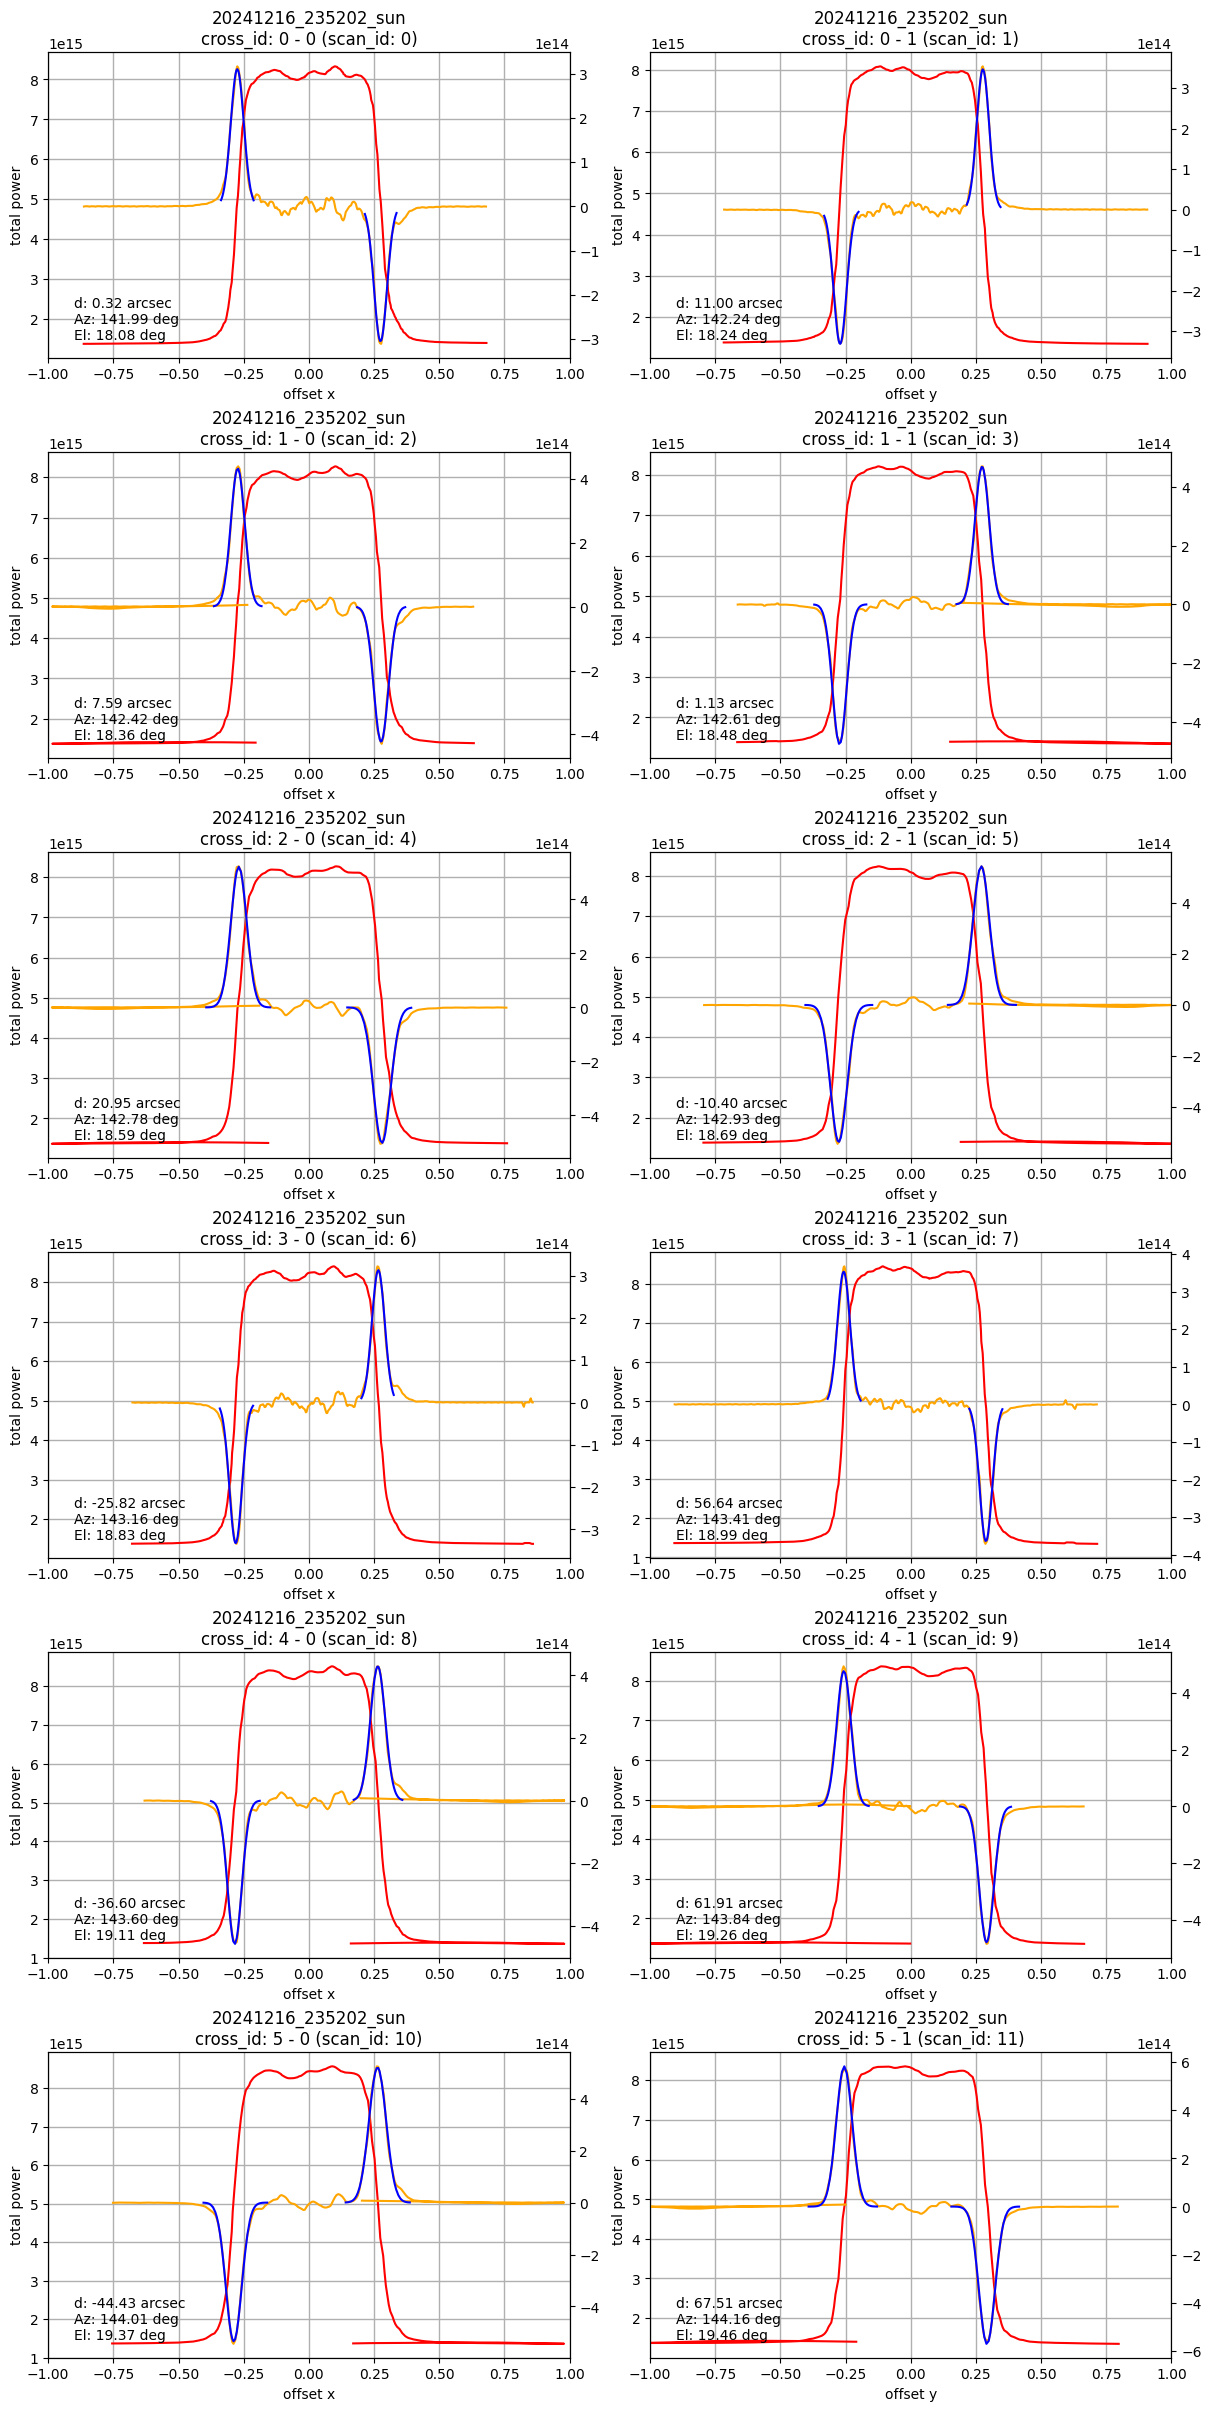

In [24]:
BAD_SCAN_ID = []  # ここは変更不要
good_scan_id = [_scan_id for _scan_id in range(scan_num) if _scan_id not in BAD_SCAN_ID]
df_save = pd.DataFrame(columns=["dt_cross_id", "scan_id", "cross_id", "axis", "dx", "dEl", "Az", "El"])
df_save.to_csv(save_path / "d_param_before_reduce.csv", index=False)
print(f"Fitting {scan_num} scan(s)...")
fig = plt.figure(figsize=(12, min((scan_num + 1) // 2 * 4, 327)), constrained_layout=True)
# fig.suptitle(str(rawdata_path))
for _scan_id in good_scan_id:
    CalcD.fit(fig=fig, cross_id=_scan_id // 2, axis=_scan_id % 2)
plt.savefig(save_path / "scans.png")

# === STOP ============================================

# データ抽出・保存【重要・要入力】
上の出力結果を見て選んだ `BAD_SCAN_ID` を以下に入力して実行するとそれを除いたデータが保存される

In [23]:
np.arange(11, 334, 12)

array([ 11,  23,  35,  47,  59,  71,  83,  95, 107, 119, 131, 143, 155,
       167, 179, 191, 203, 215, 227, 239, 251, 263, 275, 287, 299, 311,
       323])

In [22]:
# ======================================================================
BAD_SCAN_ID = [124,
      # 0,  12,  24,  36,  48,  60,  72,  84,  96, 108, 120, 132, 144,
      #  156, 168, 180, 192, 204, 216, 228, 240, 252, 264, 276, 288, 300,
      #  312, 324,   1,  13,  25,  37,  49,  61,  73,  85,  97, 109, 121, 133, 145,
      #  157, 169, 181, 193, 205, 217, 229, 241, 253, 265, 277, 289, 301,
      #  313, 325,
      # 2,  14,  26,  38,  50,  62,  74,  86,  98, 110, 122, 134, 146,
      #  158, 170, 182, 194, 206, 218, 230, 242, 254, 266, 278, 290, 302,
      #  314, 326,   3,  15,  27,  39,  51,  63,  75,  87,  99, 111, 123, 135, 147,
      #  159, 171, 183, 195, 207, 219, 231, 243, 255, 267, 279, 291, 303,
      #  315, 327,
      # 4,  16,  28,  40,  52,  64,  76,  88, 100, 112, 124, 136, 148,
      #  160, 172, 184, 196, 208, 220, 232, 244, 256, 268, 280, 292, 304,
      #  316, 328,   5,  17,  29,  41,  53,  65,  77,  89, 101, 113, 125, 137, 149,
      #  161, 173, 185, 197, 209, 221, 233, 245, 257, 269, 281, 293, 305,
      #  317, 329,
      # 6,  18,  30,  42,  54,  66,  78,  90, 102, 114, 126, 138, 150,
      #  162, 174, 186, 198, 210, 222, 234, 246, 258, 270, 282, 294, 306,
      #  318, 330,   7,  19,  31,  43,  55,  67,  79,  91, 103, 115, 127, 139, 151,
      #  163, 175, 187, 199, 211, 223, 235, 247, 259, 271, 283, 295, 307,
      #  319, 331,
      # 8,  20,  32,  44,  56,  68,  80,  92, 104, 116, 128, 140, 152,
      #  164, 176, 188, 200, 212, 224, 236, 248, 260, 272, 284, 296, 308,
      #  320, 332,   9,  21,  33,  45,  57,  69,  81,  93, 105, 117, 129, 141, 153,
      #  165, 177, 189, 201, 213, 225, 237, 249, 261, 273, 285, 297, 309,
      #  321, 333,
     # 10,  22,  34,  46,  58,  70,  82,  94, 106, 118, 130, 142, 154,
     #   166, 178, 190, 202, 214, 226, 238, 250, 262, 274, 286, 298, 310,
     #   322,  11,  23,  35,  47,  59,  71,  83,  95, 107, 119, 131, 143, 155,
     #   167, 179, 191, 203, 215, 227, 239, 251, 263, 275, 287, 299, 311,
     #   323
]  # 保存時に除外する scan_id (0, 1, 2, ...) リスト  e.g. [4, 5, 7]
# ======================================================================
good_scan_id = [_scan_id for _scan_id in range(scan_num) if _scan_id not in BAD_SCAN_ID]
print(f"GOOD_SCAN_ID = {good_scan_id}")
CalcD.reduce(good_scan_id=good_scan_id)

GOOD_SCAN_ID = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199]


# === エッジ検出ここまで ===============

# スプリアス確認
岡本くんに渡した (10/23)

In [23]:
freqs = [freq * (2500 / 32767) for freq in range(32768)]
print(freqs[0])
print(freqs[32767])
print(freqs[16384])

0.0
2500.0
1250.038148136845


1626.1024811548202
1250.038148136845
1626.1024811548202


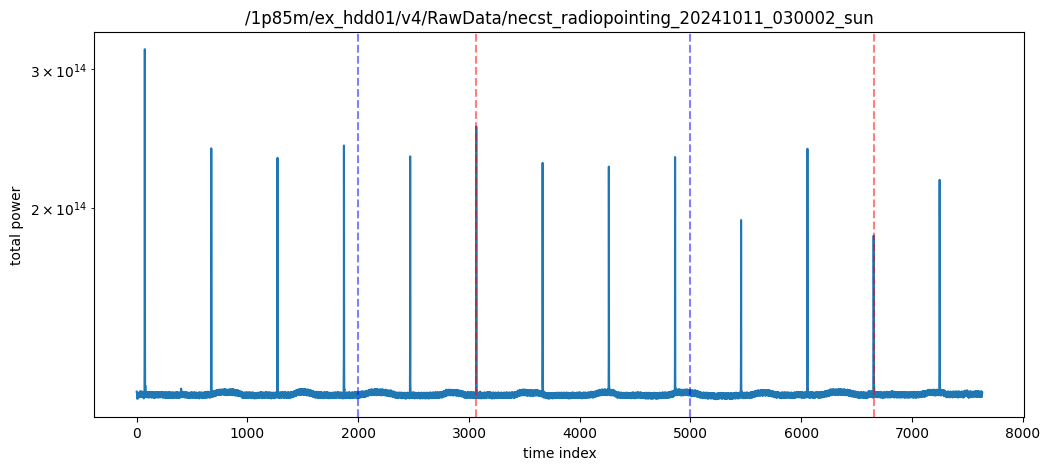

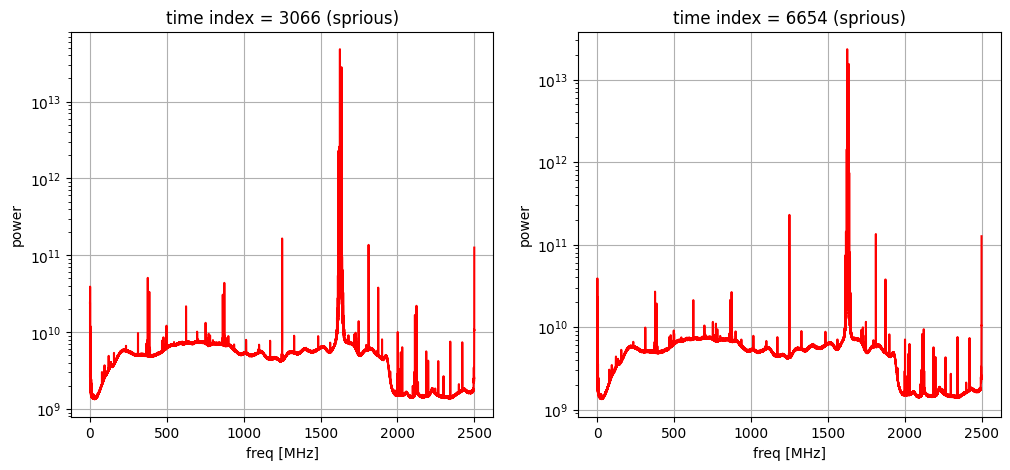

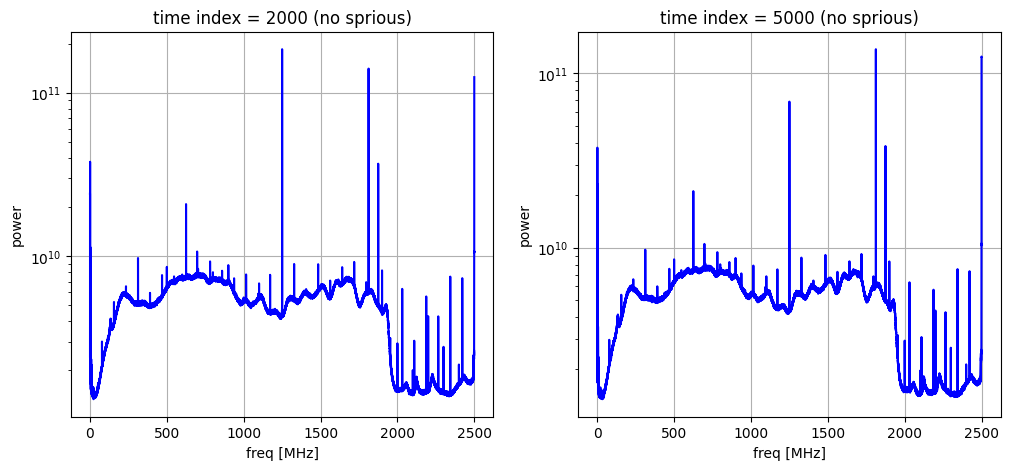

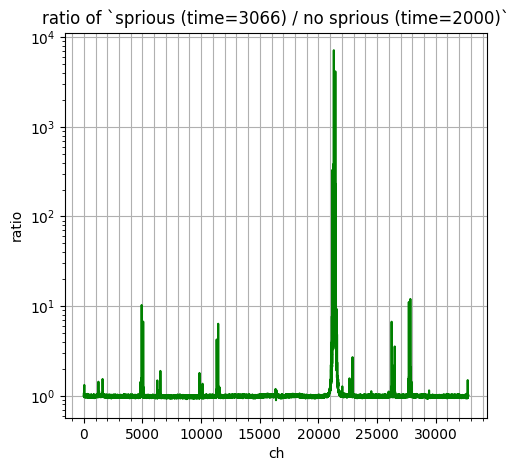

In [40]:
idx_spr = [3066, 6654]
# idx_spr = [5970, 5971, 5972]
# idx_spr = [320, 321, 322, 323, 324, 325]
idx_nospr = [2000, 5000]

print(np.argmax(data.data[idx_spr[0]]) * (2500 / 32767))
print(np.argmax(data.data[idx_nospr[0]]) * (2500 / 32767))
print(np.argmax(data.data[idx_spr[0]] / data.data[idx_nospr[1]]) * (2500 / 32767))

fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(1, 1, 1)
ax.plot(integrated)
ax.set_yscale("log")
ax.title.set_text(RAWDATA_PATH)
ax.set_xlabel("time index")
ax.set_ylabel("total power")
for t_idx in idx_spr:
    ax.axvline(x=t_idx, color="red", linestyle="--", alpha=0.5)
for t_idx in idx_nospr:
    ax.axvline(x=t_idx, color="blue", linestyle="--", alpha=0.5)
# ax.set_xlim(6650, 6660)

# fig = plt.figure(figsize=(12, 5))
# ax = fig.add_subplot(1, 1, 1)
# ax.plot(integrated)
# ax.set_yscale("log")
# ax.title.set_text(RAWDATA_PATH)
# ax.set_xlabel("time index")
# ax.set_ylabel("total power")
# ax.set_xlim(6600, 6610)

fig = plt.figure(figsize=(12, 5))
for i, t_idx in enumerate(idx_spr):
    ax = fig.add_subplot(1, len(idx_spr), i + 1)
    ax.plot(freqs, data.data[t_idx], color="red")
    ax.title.set_text(f"time index = {t_idx} (sprious)")
    ax.set_yscale("log")
    ax.set_xlabel("freq [MHz]")
    ax.set_ylabel("power")
    ax.grid()

fig = plt.figure(figsize=(12, 5))
for i, t_idx in enumerate(idx_nospr):
    ax = fig.add_subplot(1, len(idx_nospr), i + 1)
    ax.plot(freqs, data.data[t_idx], color="blue")
    ax.title.set_text(f"time index = {t_idx} (no sprious)")
    ax.set_yscale("log")
    ax.set_xlabel("freq [MHz]")
    ax.set_ylabel("power")
    ax.grid()

fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(1, 2, 1)
ax.plot(data.data[idx_spr[0]] / data.data[idx_nospr[0]], color="green")
ax.title.set_text(f"ratio of `sprious (time={idx_spr[0]}) / no sprious (time={idx_nospr[0]})`")
ax.set_yscale("log")
ax.set_xlabel("ch")
ax.set_ylabel("ratio")
ax.grid()
ax.xaxis.set_minor_locator(ticker.MultipleLocator(1000))
ax.grid(which="minor", axis="x")

# ax = fig.add_subplot(1, 2, 2)
# ax.plot(freqs, data.data[10000] / data.data[8000], color="green")
# ax.title.set_text("ratio of `no sprious (time=10000) / no sprious (time=8000)`")
# ax.set_yscale("log")
# ax.set_xlabel("freq [MHz]")
# ax.set_ylabel("ratio")